# About the dataset

## What are Brain Tumors?
A brain tumor is a mass or growth of abnormal cells in your brain.

Many different types of brain tumors exist. Some brain tumors are noncancerous (benign), and some brain tumors are cancerous (malignant). Brain tumors can begin in your brain (primary brain tumors), or cancer can begin in other parts of your body and spread to your brain as secondary (metastatic) brain tumors.



<div>
<img src="https://www.mayoclinic.org/-/media/kcms/gbs/patient-consumer/images/2014/10/30/15/17/mcdc7_brain_cancer-8col.jpg" alt="brain_tumor_image" style="width: 300px;"/>
</div>

#### In this Notebook we speak about 4 types of Brain Tumors

#### 1. Glioma

Glioma is a type of tumor that occurs in the brain and spinal cord. Gliomas begin in the gluey supportive cells (glial cells) that surround nerve cells and help them function. Three types of glial cells can produce tumors. A glioma can affect your brain function and be life-threatening depending on its location and rate of growth.
Gliomas are one of the most common types of primary brain tumors.

<div>
    <img src="https://assets.cureus.com/uploads/figure/file/164887/lightbox_0a114f70280b11eb8f411b16d840121c-final-2.png" style="width:600px;"/>
</div> 

### 2. Meningioma
A meningioma is a tumor that arises from the meninges — the membranes that surround the brain and spinal cord. Although not technically a brain tumor, it is included in this category because it may compress or squeeze the adjacent brain, nerves and vessels. Meningioma is the most common type of tumor that forms in the head. Most meningiomas grow very slowly, often over many years without causing symptoms. But sometimes, their effects on nearby brain tissue, nerves or vessels may cause serious disability.

<div>
    <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTjOeFTen8qxZfMRwXKXQlwUN0TWkMPMvzfig&usqp=CAU" style="width:700px;">
</div>

### 3. Pituitary Tumors (Adenoma)

Pituitary tumors are abnormal growths that develop in your pituitary gland. Some pituitary tumors result in too much of the hormones that regulate important functions of your body. Some pituitary tumors can cause your pituitary gland to produce lower levels of hormones. Most pituitary tumors are noncancerous (benign) growths (adenomas). Adenomas remain in your pituitary gland or surrounding tissues and don't spread to other parts of your body.



<div>
    <img src="https://assets.cureus.com/uploads/figure/file/71851/lightbox_0e62470096cb11e989a2d7e4904c7be4-Figure-2a.png" style="width:500px;"/>
</div>

## Importing the Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn import metrics
import os
import warnings
warnings.filterwarnings("ignore")


-----------
# Inspecting the dataset

In [2]:
IMG_SHAPE = (224, 224)
BATCH_SIZE = 256

## TensorFlow pipeline
We will create a dataset pipeline from our data using tensorflow dataset api

TensorFlow has a dataset api that supports writing descriptive and efficient input pipelines. a common pattern is to
- Create a source dataset from your input data.
- Apply dataset transformations to preprocess the data.
- Iterate over the dataset and process the elements.

[For more information](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [3]:
!pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Skipping, found downloaded files in "./brain-tumor-mri-dataset" (use force=True to force download)


In [4]:
data = image_dataset_from_directory('/content/brain-tumor-mri-dataset/Training',
                                    image_size= IMG_SHAPE,
                                    color_mode= 'rgb',
                                    batch_size= BATCH_SIZE,
                                    shuffle= True,
                                    seed = 2022
                                   )

Found 5712 files belonging to 4 classes.


In [5]:
print("Total number of batches: ",len(data))

Total number of batches:  23


## Displaying data distribution

In [6]:
class_names = data.class_names
for idx, name in enumerate(class_names):
  print(f"{idx} = {name}", end=", ")

0 = glioma, 1 = meningioma, 2 = notumor, 3 = pituitary, 

In [7]:
NO_CLASSES = len(class_names)
print("Number of classes = ", NO_CLASSES)

Number of classes =  4


In [8]:
labels = np.concatenate([y for x,y in data], axis=0)

In [9]:
values = pd.value_counts(labels)
values = values.sort_index()
values

0    1321
1    1339
2    1595
3    1457
dtype: int64

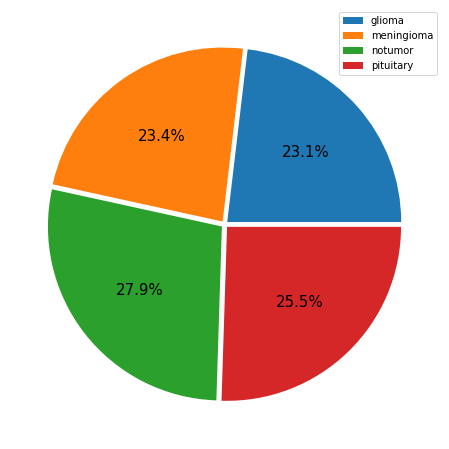

In [10]:
plt.figure(figsize=(12,8))
plt.pie(values,autopct='%1.1f%%', explode = [0.02] * len(values), textprops = {"fontsize":15})
plt.legend(labels=data.class_names)
plt.show()

#### The dataset is reasonably balanced¶


-----------

## Getting a data generator to explore the data

In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
batch = data_iterator.next()

### Each batch contains 256 images of size 224x224

In [13]:
batch[0].shape

(256, 224, 224, 3)

## Displaying some images

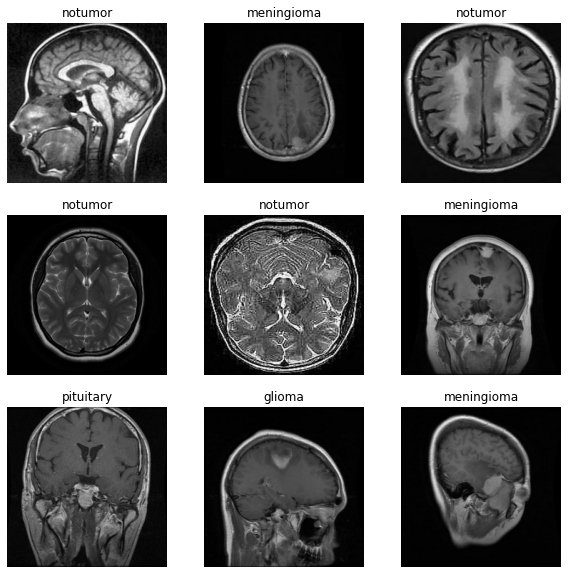

In [14]:
plt.figure(figsize=(10, 10))
for images, label in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

-------------

# Images preprocessing

## Standardizing the images
Standardization brings the pixel intensity values to the range of 0-1 such that the data points follow a **gaussian distribution** with mean of zero and standard deviation of one.

Standardizing data includes them in the same range as our **activation functions**, usually between 0 and 1. This allows for less frequent non-zero gradients during training, and therefore the neurons in our network will learn faster.

In [15]:
data = data.map(lambda x, y: (x/255., y))

In [16]:
sample = data.as_numpy_iterator().next()

In [17]:
print(sample[0].min())
print(sample[0].max())

0.0
1.0


## Class weights
Most machine learning algorithms are not very useful with biased class data. But, we can modify the current training algorithm to take into account the skewed distribution of the classes. This can be achieved by giving different weights to both the majority and minority classes. The difference in weights will influence the classification of the classes during the training phase. The whole purpose is to penalize the misclassification made by the minority class by setting a higher class weight and at the same time reducing weight for the majority class.

In [18]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(labels),
    y = labels
)

class_weights = {}
for idx, weight in enumerate(weights):
    class_weights[idx] = weight
class_weights

{0: 1.080999242997729,
 1: 1.0664675130694548,
 2: 0.8952978056426333,
 3: 0.9800960878517502}

-------------

## Splitting the data
Any Machine Learning/Deep Learning model once trained, needs to be tested on unseen data to check the performance.

- The data on which the **model trains** on is known as the **Train Dataset**.

- The unseen data on which the trained model is put to test for performance and get an **unbiased evaluation** of the final model is known as the **Test Dataset**.

- There is also an additional dataset created known as the **Validation Dataset** which validates the performance of the model fit during the **tuning phase of the model hyper-parameters**.

The percentage of data we would use to split the respective sets would be **75:15:10**. As deep learning systems need huge amount of training data, a major chunk - 75% is allocated to the training set. The validation set gets 10% share of the data and while the test set get 15% share.

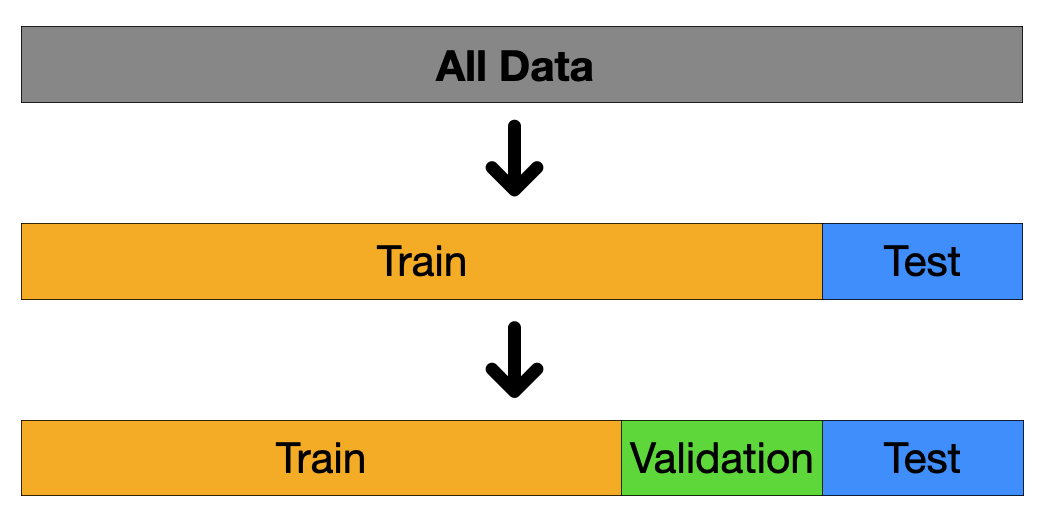

In [19]:
print("Total number of batchs = ",len(data))

Total number of batchs =  23


In [20]:
train_size = int(0.80 * len(data)) 
val_size = int(0.20 * len(data))
#test_size = int(0.15 * len(data))

In [21]:
train = data.take(train_size)
val = data.skip(train_size)
#val = remaining.take(val_size)
#test = remaining.skip(val_size)

In [22]:
print(f"# train batchs = {len(train)}, # validate batchs = {len(val)}")
len(train) + len(val) 

# train batchs = 18, # validate batchs = 5


23

-------------

# Data augmentation
The term Augmentation refers to making something larger in size. In the context of data, we try to increase the size of the dataset by creating more transformed copies of the original data. This process **increases the diversity in the dataset**. Such transformed images help to make the model more robust in handling the real-time images and increase the generalizability of the system. In the context of bio-medical image data, the samples differ from case to case basis. A similar health condition can form a completely different Whole Slide Image. Thus, a deep learning model should be **robust enough and be able to generalize** on any pattern of the slide image being fed.

Although our data is balanced, but we will randomly transform our data to increase diversity using Keras augmentatin layers, augmentaions like **flipping, rotation, translation, illumination, shift, zooming,** etc... This enables the model to learn all the variations in these data, increasing the accuracy, robustness and also help to reduce overfitting which often becomes the case with lesser data.

In [23]:
def display_aug(strategy, image):
    # Original Image
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title('Original Image')
    plt.show()

    # Augmented Image
    plt.figure(figsize=(10, 10))
    plt.title('Augmented Image')
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(strategy(batch[0][0]))
        plt.axis("off")

In [24]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

In [25]:
flip = RandomFlip("horizontal_and_vertical")
trans = RandomTranslation(0.2, 0.2)
rot = RandomRotation(0.2)
zoom = RandomZoom(0.3)
contrast = RandomContrast(0.3)

In [26]:
gen = train.as_numpy_iterator()
batch = gen.next()
img = batch[0][0]

## Random Flipping (horiziontally and vertically)

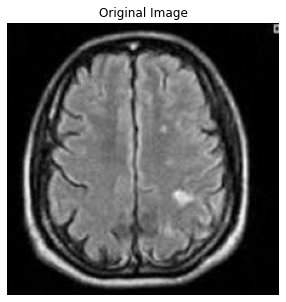

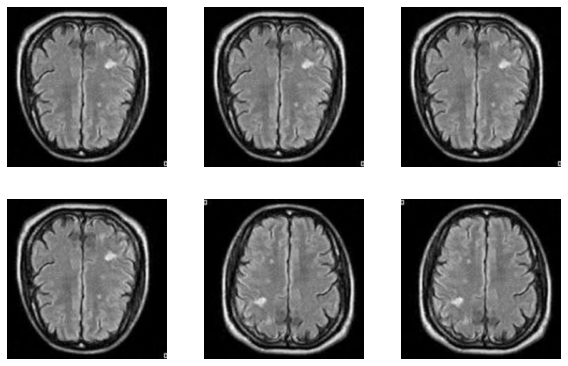

In [27]:
display_aug(flip, img)

## Random Translation (shifting)

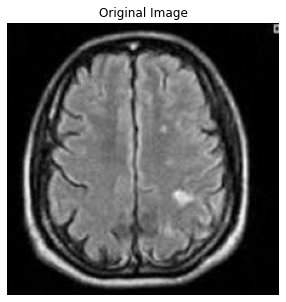

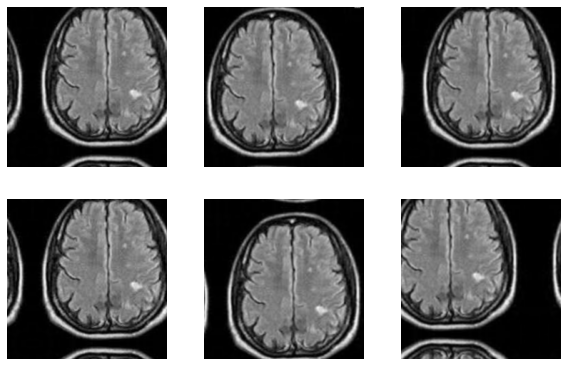

In [28]:
display_aug(trans, img)

## Random Rotation

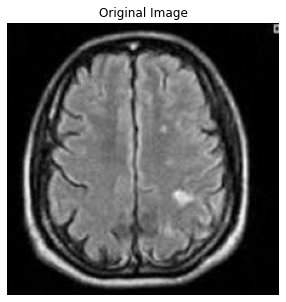

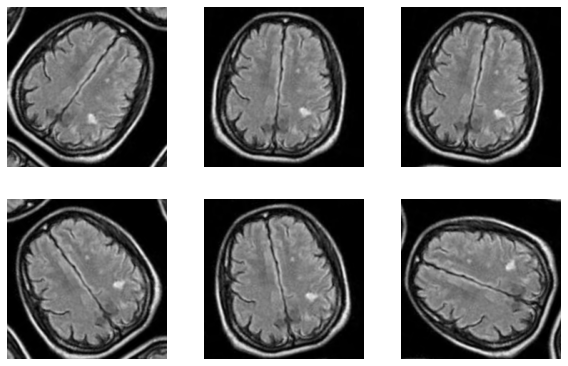

In [29]:
display_aug(rot, img)

## Random Zoom

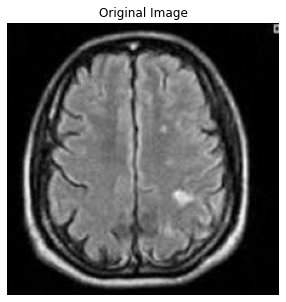

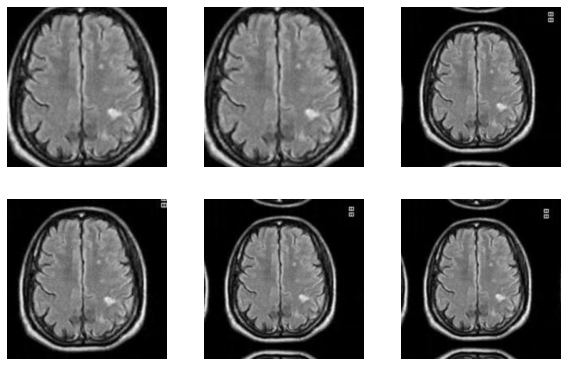

In [30]:
display_aug(zoom, img)

## Random Illumination (Contrast)

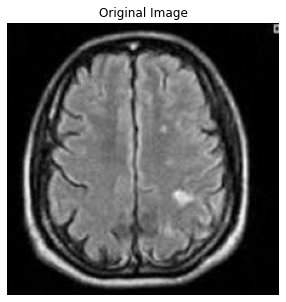

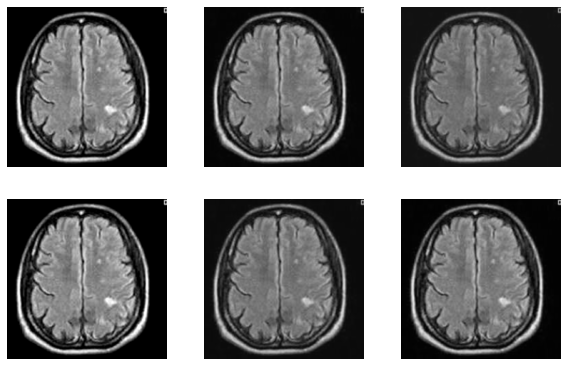

In [31]:
display_aug(contrast, img)

## All at once

In [32]:
data_aug = Sequential(
    [
        RandomFlip("horizontal_and_vertical"),
        RandomTranslation(0.2, 0.2),
        RandomRotation(0.2),
        RandomZoom(0.3),
        RandomContrast(0.3),
    ],
    name = 'augmentation'
)

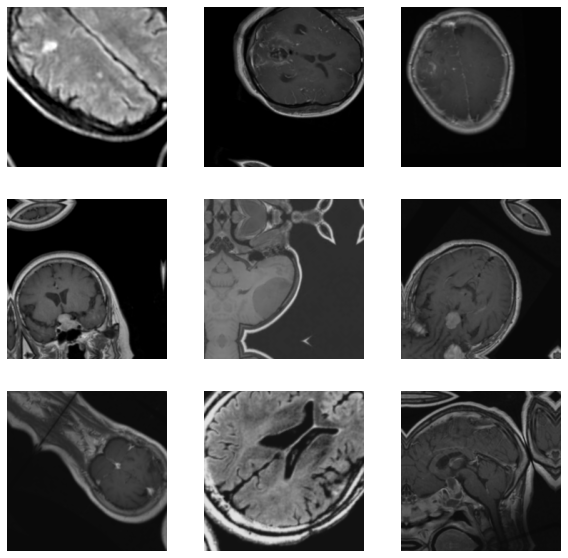

In [33]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data_aug(batch[0][i]))
    plt.axis("off")

--------------

# Modelling


In [34]:
# Displaying history loss/accuracy
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_his(history):
    plt.figure(figsize=(15,12))
    metrics = ['accuracy', 'loss']
    for i, metric in enumerate(metrics):
        plt.subplot(220+1+i)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
    plt.show()

## Transfer Learning (Pretrained Model)
#### **Here i will try to use a pretraind model, finetune it to fit our data, you can read [more about transfer learning here](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)**
#### **I used [InceptionV3](https://keras.io/api/applications/inceptionv3/) pretrained model, because the data it was trained on is different from our data, i made the layers trainable to allow it to train, fit and adapt with our data**

In [35]:
from keras.applications.inception_v3 import InceptionV3
from keras import regularizers
def make_model():
    input = Input((IMG_SHAPE[0], IMG_SHAPE[1], 3))
    aug = data_aug(input)
    inceptionv3_model = InceptionV3(include_top=False, weights="imagenet")
    inceptionv3_model.trainable=True
    
    for layer in inceptionv3_model.layers[:290]:
      layer.trainable=False

    x = inceptionv3_model(aug)
    x = GlobalAveragePooling2D(name="GAP")(x)
    x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x = Dropout(0.45)(x)        
    output=Dense(NO_CLASSES, activation='softmax', name="fc_out")(x)
    
    model= tf.keras.Model(inputs=aug, outputs=output)
    model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
    return model

In [ ]:
model = make_model()

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 GAP (GlobalAveragePooling2D  (None, 2048)             0         
 )                                                               
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 fc_out (Dense)              (None, 4)                 4100      
                                                             

In [38]:
from keras import callbacks 
Learning_Rate = callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', factor = 0.5, patience = 2, cooldown = 1, verbose = 1
)
Early_Stop = callbacks.EarlyStopping(
    monitor = 'val_loss', patience = 15, verbose = 1, mode = 'auto',restore_best_weights=True
)

## Training the model

In [39]:
history = model.fit(  
    train,
    validation_data = val,
    epochs = 50,
    callbacks = [Learning_Rate, Early_Stop],
    class_weight = class_weights
)

Epoch 1/50
18/18 [==============================] - 47s 1s/step - loss: 17.2163 - accuracy: 0.7537 - val_loss: 10.8689 - val_accuracy: 0.7935 - lr: 0.0010
Epoch 2/50
18/18 [==============================] - 24s 1s/step - loss: 6.8698 - accuracy: 0.8984 - val_loss: 3.9727 - val_accuracy: 0.8931 - lr: 0.0010
Epoch 3/50
18/18 [==============================] - 24s 1s/step - loss: 2.5060 - accuracy: 0.9280 - val_loss: 1.4967 - val_accuracy: 0.9475 - lr: 0.0010
Epoch 4/50
18/18 [==============================] - 24s 1s/step - loss: 1.0556 - accuracy: 0.9520 - val_loss: 0.7479 - val_accuracy: 0.9447 - lr: 0.0010
Epoch 5/50
18/18 [==============================] - 23s 1s/step - loss: 0.5676 - accuracy: 0.9742 - val_loss: 0.4444 - val_accuracy: 0.9846 - lr: 0.0010
Epoch 6/50
18/18 [==============================] - 24s 1s/step - loss: 0.3778 - accuracy: 0.9820 - val_loss: 0.3535 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 7/50
18/18 [==============================] - 24s 1s/step - loss: 0.3035 -

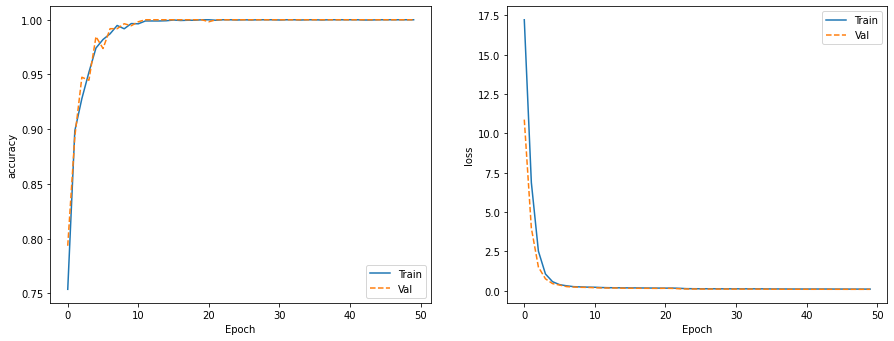

In [40]:
plot_his(history)

----------

In [41]:
model.save('model.h5')

# Evaluating test data

## Preparing test set
In order to evaluate our model we need to prepare our test set, the keras generator has shuffling which will not help us and will give wrong result, so we will transform the generator to a form we can use

In [9]:
test = image_dataset_from_directory('/content/brain-tumor-mri-dataset/Testing',
                                    image_size= IMG_SHAPE,
                                    color_mode= 'rgb',
                                    batch_size= BATCH_SIZE,
                                    shuffle= True,
                                    seed = 2022
                                   )

Found 1311 files belonging to 4 classes.


In [10]:
test = test.map(lambda x, y: (x/255., y))

In [11]:
def prepare_data(data):
    data_ls = list(data)
    imgs = []
    lbls = []
    for batch in data_ls:
        imgs.append(batch[0])
        lbls.append(batch[1])

    data_images = np.array([img for batch in np.array(imgs) for img in batch])
    data_labels = np.array([lbl for batch in np.array(lbls) for lbl in batch])
    data_set = {'images' : data_images, 'labels' : data_labels}
    return data_set


In [12]:
test_set = prepare_data(test)

In [13]:
y_true = test_set['labels']

In [14]:
def get_eval_metrics(y_true, y_pred):
    metrics_ls = ['F1', 'Precision', 'Recall', 'Accuracy']
    f1 = metrics.f1_score(y_true, y_pred, average='weighted')
    precision_score = metrics.precision_score(y_true, y_pred, average='weighted')
    recall_score = metrics.recall_score(y_true, y_pred, average='weighted')
    accuracy_score = metrics.accuracy_score(y_true, y_pred)
    scores = [f1, precision_score, recall_score, accuracy_score]

    results = pd.DataFrame(columns = ['Classification Metric', 'Score Value'])
    for i in range(len(scores)):
        results.loc[i] = [metrics_ls[i], scores[i]] 
    
    return results

In [48]:
y_pred = model.predict(test_set['images'])
y_pred = np.round(y_pred) if NO_CLASSES == 2 else np.argmax(y_pred, 1)

41/41 [==============================] - 7s 104ms/step


In [49]:
results = get_eval_metrics(y_true, y_pred)
results.groupby('Classification Metric').head()

,Classification Metric,Score Value
0,F1,0.968635
1,Precision,0.969183
2,Recall,0.968726
3,Accuracy,0.968726


### As we see these results are the predictions for each image in test set, but one thing we can do to increase inference accuracy is to augment our test data same as we did with the training set, so lets try that out and see if it would get the results any where better

--------
## Test-time augmentation
**Test-Time Data Augmentation** (short TTA) is a technique that can **boost** a model's performance by applying augmentation during **inference** and is a popular strategy to use with deep learning models.
Inference is performed on multiple **altered** versions of the same image, and the predictions are then **aggregated** to get a higher overall accuracy.
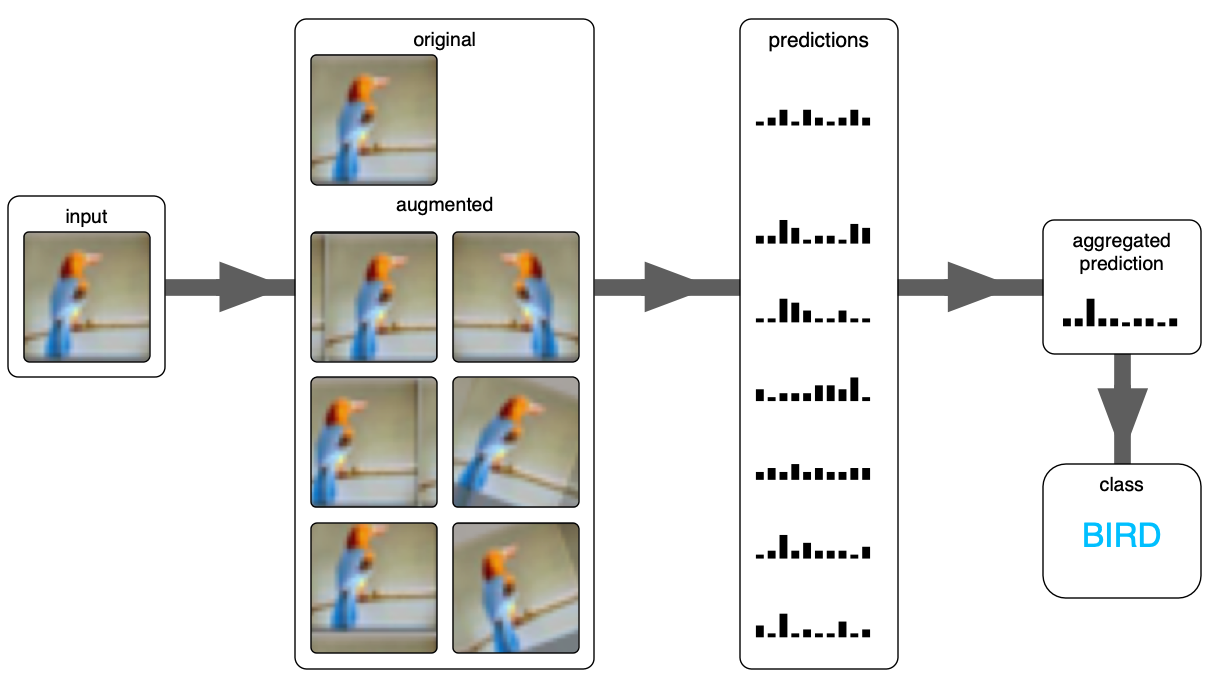

### We will apply multiple of augmentation on each image such as **cropping**, **shifting**, **rotating** and **flipping** with total of **13** variation per images and finally get their average prediction

In [34]:
import scipy as sp

########## Cropping ############
# get five crops of each image, 4 corners crops and a center crop
def five_crop(x_test, ratio):
    
    def crop(image, ratio, box):
        images = tf.image.crop_and_resize(image, box, [0], IMG_SHAPE)
        return images
        
    boxes = np.array(
        [
            [0, 0, 1-ratio, 1-ratio],
            [0, ratio , 1-ratio, 1.],
            [ratio, 0, 1., 1-ratio],
            [ratio, ratio, 1., 1.],
            [ratio/2, ratio/2, 1-ratio/2, 1-ratio/2],
        ]
    )
    
    for box in boxes:
        images = []
        for img in test_set['images']:
            cropped = crop(img.reshape(-1,IMG_SHAPE[0], IMG_SHAPE[1],3), ratio, np.array([box]))
            images.append(cropped)
        yield np.array(images)
        del images

######### flipping ############
# flipping images horizontally and/or vertically
def flip_lr(images, axis):
    return np.flip(images, axis=axis)

########## shifting ############
# shifting or translating images on X or Y axis with specific amount
def shift(images, shift, axis):
    return np.roll(images, shift, axis=axis)

########## rotating #############
# rotating images by some degrees
def rotate(images, angle):
    return sp.ndimage.rotate(
        images, angle, axes=(1,2),
        reshape=False, mode='nearest')

########## fast_pred ########
# Prediciting images on the fly without saving the augmented transforms (save memory)
def fast_pred(X_test):
    predictions = []
    
    predictions.append(model.predict(X_test))

    predictions.append(model.predict(flip_lr(X_test,2)))
    predictions.append(model.predict(flip_lr(X_test,1)))
    
    predictions.append(model.predict(shift(X_test, -4, axis=2)))
    predictions.append(model.predict(shift(X_test, 4, axis=2)))
    
    predictions.append(model.predict(shift(X_test, -4, axis=1)))
    predictions.append(model.predict(shift(X_test, 4, axis=1)))
    
    predictions.append(model.predict(rotate(X_test, -10)))
    predictions.append(model.predict(rotate(X_test, 10)))
    
    for crop in five_crop(test_set['images'], 0.1):
        predictions.append(model.predict(crop.squeeze(1)))
    
    stack = np.mean(np.stack(predictions), axis=0)
    preds = np.round(stack) if NO_CLASSES == 2 else np.argmax(stack, 1)
    return preds

########### combine_augmentations ###########
# get list of all transformed images
def augment_images(X_test):
    fv = flip_lr(X_test,2)
    
    fh = flip_lr(X_test,1)
    
    w0 = shift(X_test, -3, axis=2)
    w1 = shift(X_test, 3, axis=2)
    
    h0 = shift(X_test, -3, axis=1)
    h1 = shift(X_test, 3, axis=1)
    
    r0 = rotate(X_test, -10)
    r1 = rotate(X_test, 10)
    
    cropped_images = five_crop(X_test, 0.2)
    cropped = []
    for image in cropped_images:
        cropped.append(image)
    
    return [fv, fh, w0, w1, h0, h1, r0, r1] + cropped

############ prediction ##########
# predicit images and get their mean prediction
def predict_images(augmented_images, y_true):
    predictions = []
    
    for aug in augmented_images:
        pred = model.predict(aug)
        predictions.append(pred)
    
    stack = np.mean(np.stack(predictions), axis=0)
    preds = np.round(stack) if NO_CLASSES == 2 else np.argmax(stack, 1)
    return preds


def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(NO_CLASSES)+.5, class_names, rotation=90)
    plt.yticks(np.arange(NO_CLASSES)+.5, class_names, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")


In [30]:
y_pred = fast_pred(test_set['images'])

41/41 [==============================] - 3s 74ms/step


In [31]:
results = get_eval_metrics(y_true, y_pred)
results.groupby('Classification Metric').head()

,Classification Metric,Score Value
0,F1,0.973992
1,Precision,0.974450
2,Recall,0.974066
3,Accuracy,0.974066


In [32]:
print(classification_report(y_true, y_pred, target_names = class_names))

              precision    recall  f1-score   support

      glioma       0.98      0.93      0.95       300
  meningioma       0.93      0.96      0.95       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



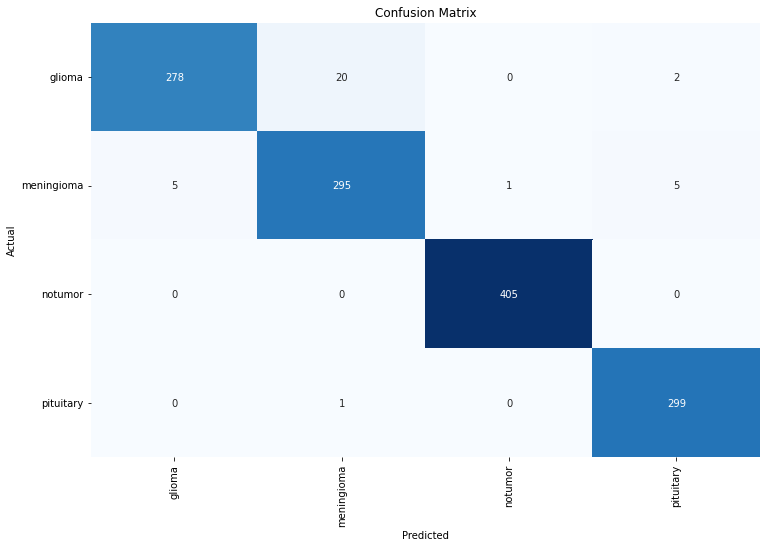

In [35]:
plot_cm(y_true, y_pred)

# Conclusion
We used transfer learning as our main technique for training our data with the pretrained model InceptionV3, before modelling, we preprocessed the data in many ways including normalizing, balancing the data with class weights and different augmentation techniques, finally we used augmentaion too in our inference stage to get more accurate results